# **Open Food Fact :**

## **Introduction :**
The Open Food Fact is a collaborative dataset of food products from arount the world, with ingredients, allergens, nutrition facts and all information we can find on product labels.
Open Food Facts Database is a 2.1GB CSV file with tab separators. We will use the folowing features for our analysis :<br>

- Nutrition: features related to nutriements<br>
- Ingredients: features about composition of the food <br>
- Tag: information about product_name, countrie etc...

In [275]:
import pandas as pd
import numpy as np
import re
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns
from sklearn import manifold, datasets
from adjustText import adjust_text
import math

In [67]:
openfoodfacts = pd.read_csv('dataset_open_food.csv','\t')
print('Shape of the dataset:',openfoodfacts.shape)
openfoodfacts.head()

Shape of the dataset: (1005487, 175)


,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
0,0000000000017,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1529059080,2018-06-15T10:38:00Z,1561463718,2019-06-25T11:55:18Z,Vitória crackers,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000000031,http://world-en.openfoodfacts.org/product/0000...,isagoofy,1539464774,2018-10-13T21:06:14Z,1539464817,2018-10-13T21:06:57Z,Cacao,NaN,130 g,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,00000000001111111111,http://world-en.openfoodfacts.org/product/0000...,openfoodfacts-contributors,1560020173,2019-06-08T18:56:13Z,1560020173,2019-06-08T18:56:13Z,Sfiudwx,NaN,dgesc,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0000000000123,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1535737982,2018-08-31T17:53:02Z,1535737986,2018-08-31T17:53:06Z,Sauce Sweety chili 0%,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0000000000178,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1542456332,2018-11-17T12:05:32Z,1542456333,2018-11-17T12:05:33Z,Mini coco,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## **A.1 Cleanning the dataset:**

This dataset is not clean and full of missing values ('NaN'), cleaning this dataset is primordiale before any analysis. From the histogram below, we can observe that more tha 100 columns have 1 millions missing values.
In addition, it is important to note that removing all NaN values will leave us with an empty DataFrame.

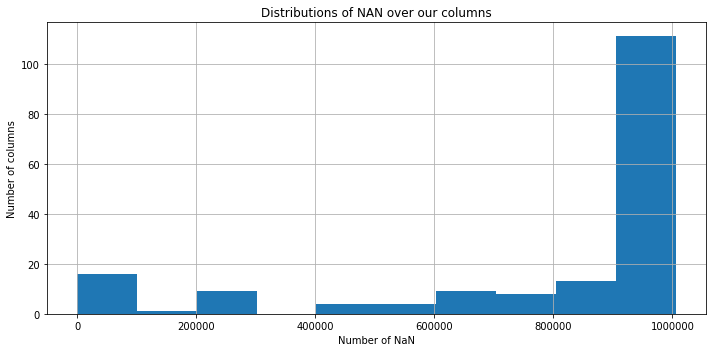

In [68]:
nan_column = openfoodfacts.isnull().sum(axis=0).sort_values(ascending=False)
plt.figure(figsize=(10,5))
plt.title('Distributions of NAN over our columns')
nan_column.hist(bins='auto')
plt.xlabel('Number of NaN')
plt.ylabel('Number of columns')
plt.tight_layout()
plt.show()

We focuse our analysis on American products,this is a decision we made in order to complete the Dunhumby dataset which is the US.
We will focus mainly on the nutrition table below, this will help to correct mistakes in the dataset. By comparing the energy_100g and calculated energy from carbohydrates, proteins and fat, we can delet some wrong entries.
If the sum of element in 100g of product is more than 100g this entry is wrong and can be deleted.

In [76]:
nutrition_table_cols = ["product_name", "ingredients_text", "allergens","energy_100g",
                        "fat_100g",
                        "carbohydrates_100g",
                        "sugars_100g",
                        "proteins_100g",
                        "salt_100g",
                        "allergens",
                        "ingredients_from_palm_oil",
                       "additives","countries_en"]

In [81]:
df_nutrition = openfoodfacts[nutrition_table_cols].copy()
interest = df_nutrition.product_name.dropna().index.intersection(df_nutrition.ingredients_text.dropna().index)
interest = interest.intersection(df_nutrition[df_nutrition.countries_en == "United States"].index)
df_nutrition = df_nutrition.iloc[interest]
df_nutrition.head()

,product_name,ingredients_text,allergens,energy_100g,fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,allergens,ingredients_from_palm_oil,additives,countries_en
42,Banana Chips Sweetened (Whole),"Bananas, vegetable oil (coconut oil, corn oil ...",NaN,2243.0,28.57,64.29,14.29,3.57,0.00000,NaN,NaN,NaN,United States
43,Peanuts,"Peanuts, wheat flour, sugar, rice flour, tapio...",NaN,1941.0,17.86,60.71,17.86,17.86,0.63500,NaN,NaN,NaN,United States
92,Organic Salted Nut Mix,"Organic hazelnuts, organic cashews, organic wa...",NaN,2540.0,57.14,17.86,3.57,17.86,1.22428,NaN,NaN,NaN,United States
93,Organic Polenta,Organic polenta,NaN,1552.0,1.43,77.14,NaN,8.57,NaN,NaN,NaN,NaN,United States
94,Breadshop Honey Gone Nuts Granola,"Rolled oats, grape concentrate, expeller press...",NaN,1933.0,18.27,63.46,11.54,13.46,NaN,NaN,NaN,NaN,United States


In [83]:
df_nutrition["sum_elements"] = df_nutrition.fat_100g + df_nutrition.carbohydrates_100g +\
                            df_nutrition.proteins_100g

df_nutrition["sum_elements"] = round(df_nutrition.sum_elements)

df_nutrition["other_carbs"] = df_nutrition.carbohydrates_100g - df_nutrition.sugars_100g

df_nutrition["reconstructed_energy"] = df_nutrition.fat_100g * 37 + \
                                            (df_nutrition.proteins_100g + df_nutrition.carbohydrates_100g)* 17
df_nutrition.head()

,product_name,ingredients_text,allergens,energy_100g,fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,allergens,ingredients_from_palm_oil,additives,countries_en,sum_elements,other_carbs,reconstructed_energy
42,Banana Chips Sweetened (Whole),"Bananas, vegetable oil (coconut oil, corn oil ...",NaN,2243.0,28.57,64.29,14.29,3.57,0.00000,NaN,NaN,NaN,United States,96.0,50.00,2210.71
43,Peanuts,"Peanuts, wheat flour, sugar, rice flour, tapio...",NaN,1941.0,17.86,60.71,17.86,17.86,0.63500,NaN,NaN,NaN,United States,96.0,42.85,1996.51
92,Organic Salted Nut Mix,"Organic hazelnuts, organic cashews, organic wa...",NaN,2540.0,57.14,17.86,3.57,17.86,1.22428,NaN,NaN,NaN,United States,93.0,14.29,2721.42
93,Organic Polenta,Organic polenta,NaN,1552.0,1.43,77.14,NaN,8.57,NaN,NaN,NaN,NaN,United States,87.0,NaN,1509.98
94,Breadshop Honey Gone Nuts Granola,"Rolled oats, grape concentrate, expeller press...",NaN,1933.0,18.27,63.46,11.54,13.46,NaN,NaN,NaN,NaN,United States,95.0,51.92,1983.63


In [84]:
print(df_nutrition.reconstructed_energy.describe())
print('='*40)
print(df_nutrition.energy_100g.describe())
print('='*40)
print(df_nutrition.sum_elements.describe())

count    169282.000000
mean       1146.580820
std         822.046523
min      -13600.000000
25%         354.985000
50%        1153.620000
75%        1700.000000
max       12321.000000
Name: reconstructed_energy, dtype: float64
count    170234.000000
mean       1131.014555
std         980.842778
min           0.000000
25%         360.000000
50%        1142.000000
75%        1674.000000
max      231199.000000
Name: energy_100g, dtype: float64
count    169282.000000
mean         52.870583
std          34.739996
min        -800.000000
25%          19.000000
50%          53.000000
75%          88.000000
max         641.000000
Name: sum_elements, dtype: float64


We notice that there are some obvious outliers :<br>

- There are some negative values in the calculated energy.<br>
- Energy amount exceeding 3700kJ (the maximum energy amount a product can have is 3700kJ and it corresponds to 100% of fat)
- The sum of elements (fat_100g,carbohydrates_100g and proteins_100g) is negative in certain case and also higher than 100

We can detect the entries that are wrong.

In [85]:
df_nutrition = df_nutrition.loc[df_nutrition.reconstructed_energy<=3700]
df_nutrition = df_nutrition.loc[df_nutrition.reconstructed_energy>0]
df_nutrition = df_nutrition.loc[df_nutrition.sum_elements<=100]
df_nutrition = df_nutrition.loc[df_nutrition.sum_elements>0]
df_nutrition = df_nutrition.loc[df_nutrition.energy_100g>0]
df_nutrition = df_nutrition.loc[df_nutrition.energy_100g<=3700]
df_nutrition.head()

,product_name,ingredients_text,allergens,energy_100g,fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,allergens,ingredients_from_palm_oil,additives,countries_en,sum_elements,other_carbs,reconstructed_energy
42,Banana Chips Sweetened (Whole),"Bananas, vegetable oil (coconut oil, corn oil ...",NaN,2243.0,28.57,64.29,14.29,3.57,0.00000,NaN,NaN,NaN,United States,96.0,50.00,2210.71
43,Peanuts,"Peanuts, wheat flour, sugar, rice flour, tapio...",NaN,1941.0,17.86,60.71,17.86,17.86,0.63500,NaN,NaN,NaN,United States,96.0,42.85,1996.51
92,Organic Salted Nut Mix,"Organic hazelnuts, organic cashews, organic wa...",NaN,2540.0,57.14,17.86,3.57,17.86,1.22428,NaN,NaN,NaN,United States,93.0,14.29,2721.42
93,Organic Polenta,Organic polenta,NaN,1552.0,1.43,77.14,NaN,8.57,NaN,NaN,NaN,NaN,United States,87.0,NaN,1509.98
94,Breadshop Honey Gone Nuts Granola,"Rolled oats, grape concentrate, expeller press...",NaN,1933.0,18.27,63.46,11.54,13.46,NaN,NaN,NaN,NaN,United States,95.0,51.92,1983.63


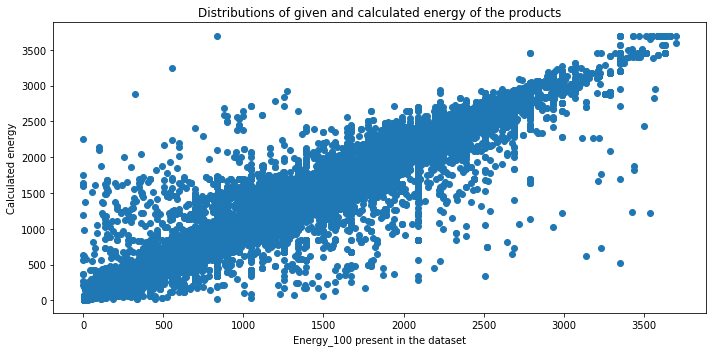

In [86]:
# Visualization of the errors
plt.figure(figsize=(10,5))
plt.title('Distributions of given and calculated energy of the products')
plt.scatter(df_nutrition["energy_100g"], df_nutrition["reconstructed_energy"])
plt.xlabel('Energy_100 present in the dataset')
plt.ylabel('Calculated energy')
plt.tight_layout()
plt.show()

The relation between the calculated energy is linearly correlated with the given energy.The cleaning process is succesful for this part.

##  **A.2 Analysis and Data Visualization:**

The challenge is now to parse and extract useful information from this ingredients text fields. It looks like there is no particular format in the data, except that the ingredients are separated by commas. The first intuition is to take advantage of that, namely split the ingredients on the comma character, trim them, convert them lower case string and explode the resulting series. This already gives a decent result but many rows contain additional data such as quantity, that affects our grouping function. It turns out using some regular expressions we can normalize most of the rows without much work.

In [107]:
# Pipeline to extract the ingredients - can be improved but already works quite well
ingredients = df_nutrition.ingredients_text.apply(lambda s: list(map(lambda t: t.strip(), re.sub("\(.+?\)", '', s.lower()).split(','))))
ingredients = ingredients.explode()
exploded = ingredients.str.lower().str.replace("^.*?[0-9]+[^ ]*? ", '').str.replace(" [0-9].*$", '').str.replace("([0-9]*%|\.|[_\(\)\:\*\[\]])", '').str.replace('^[0-9]+$', '').str.strip()
exploded = exploded.str.replace(' +', ' ').str.replace('œ', 'oe').str.replace('[éèêë]', 'e').str.replace('[àâä]', 'a').str.replace('[îï]', 'i').str.replace('[uûùü]', 'u').str.replace('[ôö]', 'o')
exploded = exploded[exploded.apply(lambda s: len(s) > 0)]

by_count = pd.Series(exploded).value_counts()

In [229]:
counts = pd.DataFrame()
counts['ingredient'] = list(by_count.index)
counts['apparition'] = list(by_count)

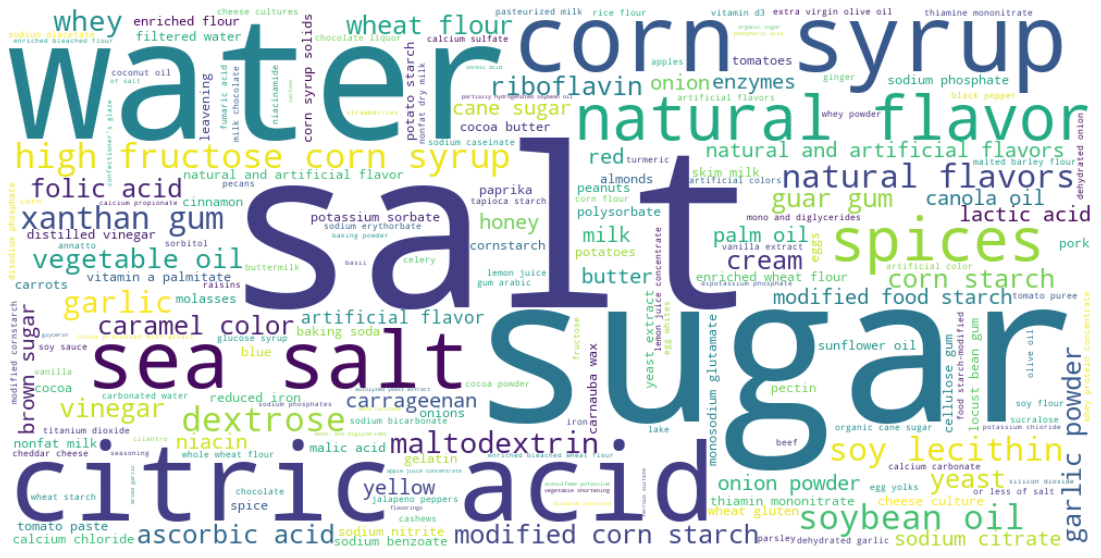

In [234]:
d = {}
counter = 0
for a in counts.ingredient:
    d[a] = counts.apparition[counter]
    counter = counter + 1
    
    
wordcloud = WordCloud(width = 1000, height = 500, background_color="white")
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

With this first analysis we can already see some patterns obvious emerging: without any surprise the three most common ingredients are salt, sugar and water.

Now we would like to plot our products on a 2D map grouped by clusters given their ingredients. This can be done using a dimensionality reduction algorithm. One of them is called t-SNE and can achieve this task fairly efficiently. The idea is to create a matrix of products which has 1k columns, one for each ingredient in the ranking by number of occurrence, and each cell containing a binary value describing if the ingredient is present or absent for this product. Ingredients beyond this ranking are irrelevant because they appear only so rarely, moreover it would make the algorithm unnecessarily slower.

In [236]:
# Number of ingredients (= dimensions) to consider
n_dimensions = 1000
# Number of rows (= datapoints) to consider at most
n_rows = 100000

# Minimum number of ingredients appearing in the list
min_ingredients = 3

relevant = by_count.head(n_dimensions).index.tolist()
products = exploded.iloc[df_nutrition.head(n_rows).index]

values = {}
for col in relevant:
    values[col] = products.apply(lambda s: 1 if s == col else 0).groupby(products.index).max()
matrix = pd.DataFrame(values)

matrix = matrix[matrix.sum(axis=1) >= min_ingredients]

In [237]:
matrix.head(5)

,salt,sugar,water,citric acid,corn syrup,sea salt,natural flavor,spices,high fructose corn syrup,dextrose,...,semi-sweet chocolate chips,molasses powder,extractive of paprika,organic peanuts,asparagus,invertase,red cabbage,diced pears,pasteurized whole milk,shellac
115,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
117,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
118,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
126,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
128,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The matrix has the shape we want. Note that in the mean time we dropped rows with less than 3 ingredients in the matrix because they would create irrelevant datapoint.

We are now ready to apply the algorithm on the matrix. The execution takes some time.

In [239]:
X = matrix.head(10000)

n_components = 2 # Number of dimensions to reduce to
perplexity = 100 # t-SNE parameter (the higher the better the result, but also the more expensive)
tsne = manifold.TSNE(n_components=n_components, init='random', random_state=0, perplexity=perplexity)
Y = tsne.fit_transform(X)


In [264]:
def highlight(f, n_labels):
    x, y = Y.T
    names = df_nutrition.product_name[X.index]
    names_list = names.tolist()
    colors = names.apply(lambda s: 'red' if f(s) else 'lightgray').tolist()
    
    fig, ax = plt.subplots(figsize=(10,10))

    sc = plt.scatter(x, y, c=colors, s=5)
    
    texts = [plt.text(x[i], y[i], names_list[i], fontsize=7) for i in np.random.choice(len(X), n_labels)]
    adjust_text(texts)

    plt.show()

Here we plot some labels to roughly familiarize ourselves with the shape of our map. Here are some possible clusters that the algorithm might have identified:

-Chocolate sweets <br>
-Fruit biscuits<br>
-Fishes<br>
-Cheeses<br>
We'll see later a robust method to confirm this intuition.

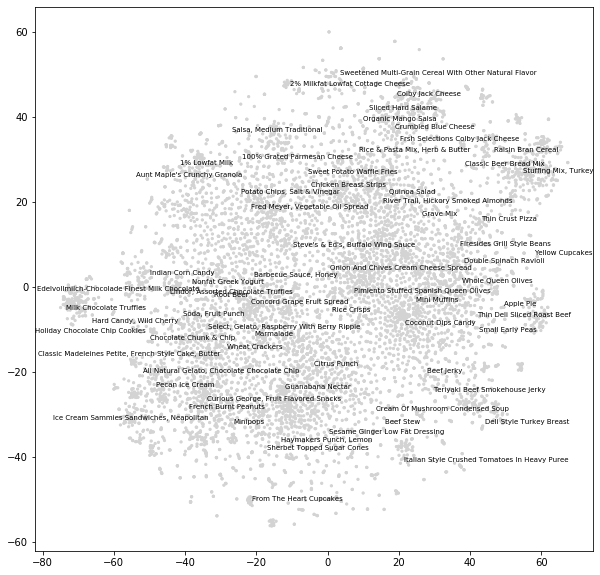

In [265]:
highlight(lambda s: False, 70)

In fact we want to make sure that the clustering is actually meaningful, one way to do that is to prove that the reduced dimensionality is correlated with an independent variable (= unused in the algorithm). One such variable would be the product name. Here we plot in red the products having chocolat in their name. Clearly the product names are correlated with the reduced dimensions. It also confirms the existence of one of the cluster we hypothesized earlier ("chocolate sweets").

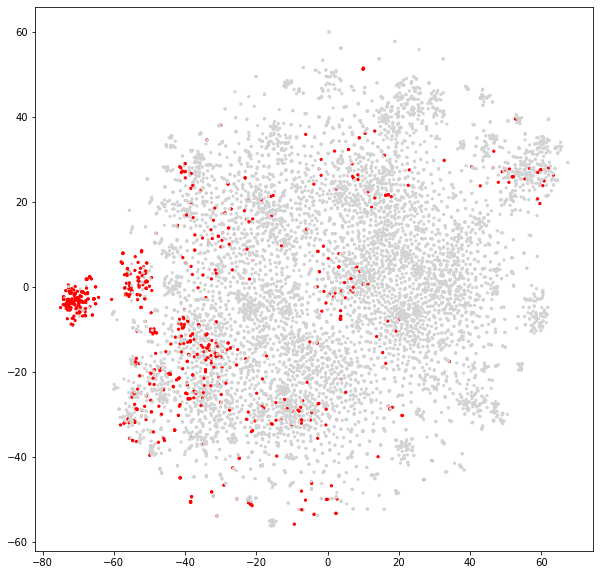

In [266]:
highlight(lambda s: 'chocolate' in s.lower(), 0)

Here are some other examples with more keywords:

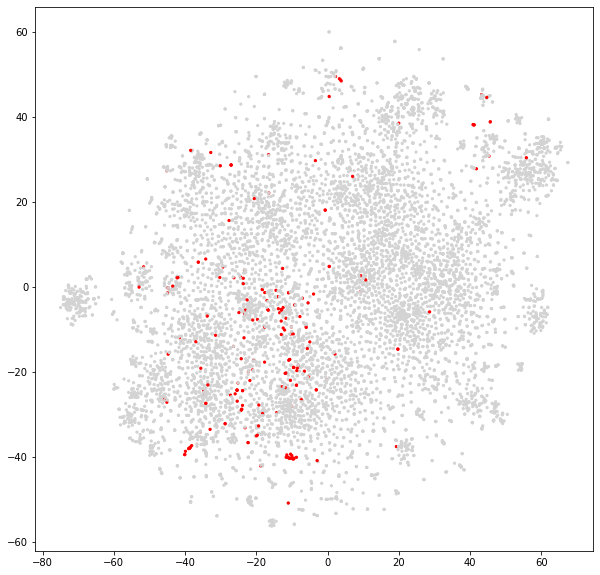

In [267]:
highlight(lambda s: 'fruit' in s.lower(), 0)

In [268]:
def highlight2(cols, title):
    x, y = Y.T
    
    def exists_col(r):
        for c in cols:
            if r[c] == 1:
                return True
        return False
    
    colors = matrix.loc[X.index.intersection(matrix.index)].apply(lambda r: 'red' if exists_col(r) else 'lightgray', axis=1).tolist()
    
    fig, ax = plt.subplots(figsize=(10,10))

    plt.axis('off')
    
    sc = plt.scatter(x, y, c=colors, s=5)
    
    texts = [plt.text(x[i], y[i], names_list[i], fontsize=7) for i in np.random.choice(len(X), 0)]
    adjust_text(texts)

    plt.title(title)
    
    plt.show()

Let's highlight the ingredients individually to reason about our previous discoveries. Remark that we cannot make any conclusion about the position of the clusters in these plots because it is merely the result of a data representation algorithm. Simply put we only reordered the points so that products with similar ingredients fall close to each other

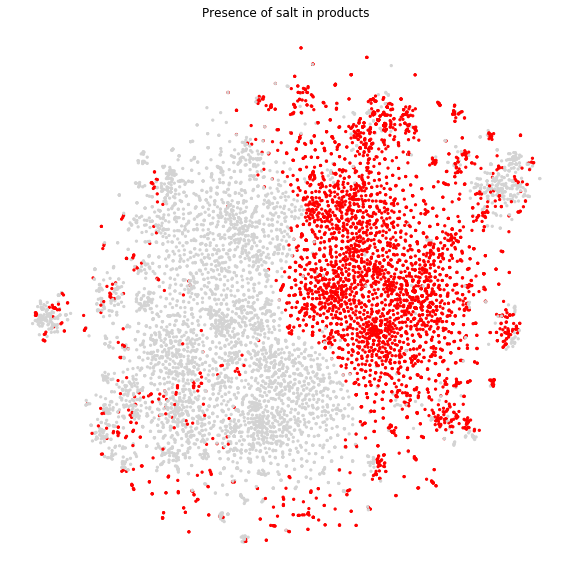

In [269]:
highlight2(['salt'], 'Presence of salt in products')

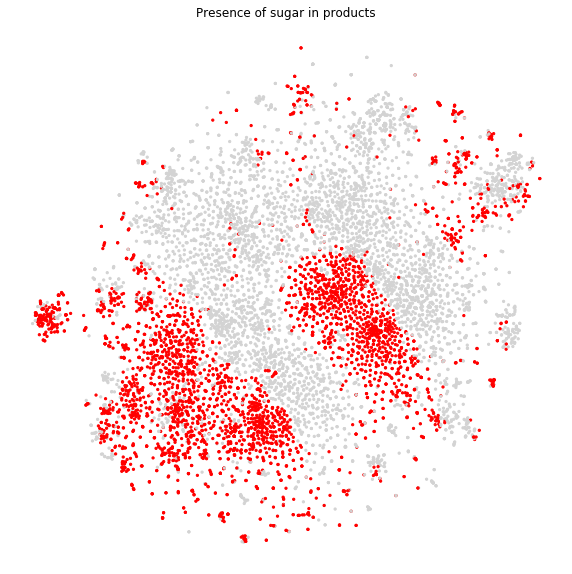

In [270]:
highlight2(['sugar'], 'Presence of sugar in products')

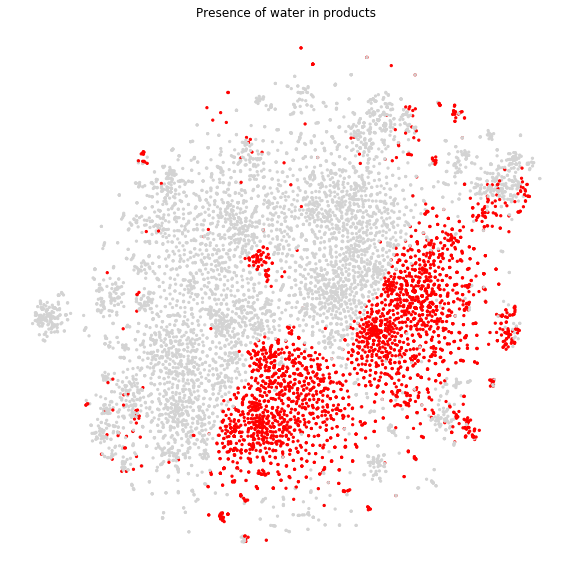

In [271]:
highlight2(['water'], 'Presence of water in products')

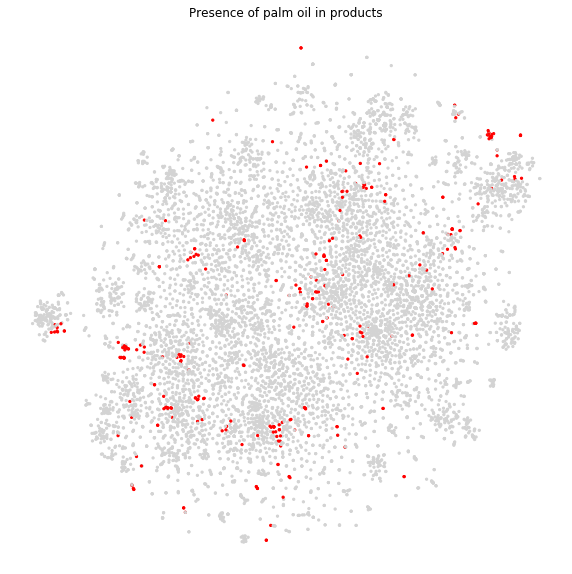

In [272]:
highlight2(['palm oil'], 'Presence of palm oil in products')

In [273]:
# Size of the correlation matrix
n_correlations = 20

cmatrix = np.zeros((n_correlations, n_correlations))
columns = matrix.columns.tolist()[:n_correlations]

# https://en.wikipedia.org/wiki/Phi_coefficient
def phi_corr(n):
    top = n[1][1] * n[0][0] - n[1][0] * n[0][1]
    bot = math.sqrt((n[1][0] + n[1][1]) * (n[0][0] + n[0][1]) \
                    * (n[0][0] + n[1][0]) * (n[0][1] + n[1][1]))
    return top / bot
    
for i in range(n_correlations):
    a = columns[i]
    for j in range(i):
        b = columns[j]
        m = matrix[[a, b]]
        vs = [0, 1]
        result = np.zeros((len(vs), len(vs)))
        for x in vs:
            for y in vs:
                result[x][y] = len(m[(m[a] == x) & (m[b] == y)])

        cmatrix[i][j] = phi_corr(result)

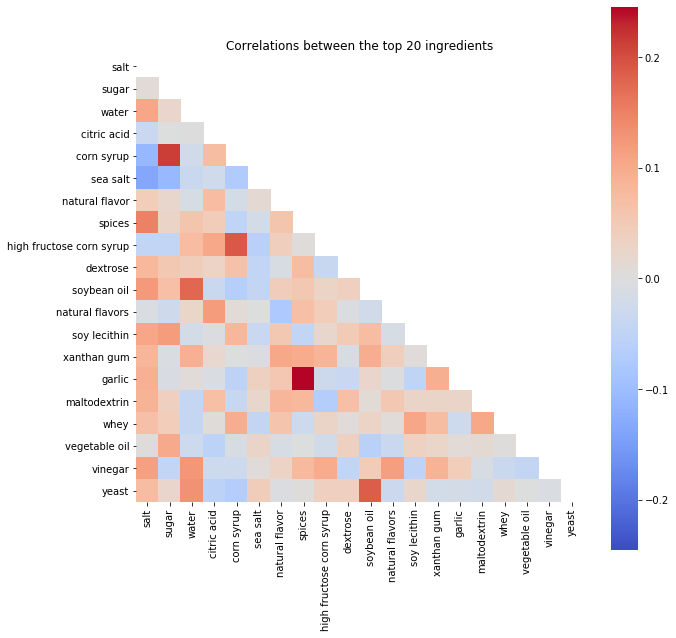

In [274]:
mask = np.zeros_like(cmatrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

m = np.max(np.abs(cmatrix))

fig, ax = plt.subplots(figsize=(10,10))
ax.set_title('Correlations between the top %s ingredients' % n_correlations)
sns.heatmap(cmatrix, ax=ax, square=True, mask=mask, vmin=-m, vmax=m, xticklabels=columns, yticklabels=columns, cmap='coolwarm');